In [ ]:
import numpy as np
import matplotlib.pyplot as plt


#"Our house is burning down and we're blind to it" Project

##Motivation

My rabbit Bibi complains of being too hot. I told him he'd better go to the groomer to get his
fleece cut but he replied that the problem is more fundamental: according to him, the climate is getting warmer!

If we listen to the IPCC, this would be due to the carbon cycle going haywire. On site https://exchange.iseesystems.com/public/globeprogam/global-carbon-cycle-model-with-feedbacks/index.html you can
find a carbon cycle simulator. The equations seem correct but nothing says that the resolution algorithm used in this simulator is correct. In fact, I'm quite skeptical about the results and I'm afraid that environmental hackers have tampered with the results. I would preferr a program in which we control all the elements. It should indeed be ensured that what is calculated is in good agreement with reality. It seems that the concepts of consistency and stability are the key to guarantee the reliability of numerical methods...

I would need your help to con
firm or refute the conclusions of the IPCC and to simulate the temperature variation for the years to come. Then we could check if we need to modify our carbon dioxyde emissions pro
le for Bibbi to stop complaining.



##Learning Objectives

* Implement numerical methods for solving differential equations
* Explain the functions involved in a differential equation to study their properties
* Demonstrate the convergence of a numerical method
* Comparing the performance of numerical methods

##Initialization codes

Initialization conditions

In [ ]:
Atmosphere_Initial = 750.0
CarbonateRock_Initial = 100000000.0
DeepOcean_Initial = 38000.0
FossilFuel_Initial = 7500.0
Plant_Initial = 560.0
Soil_Initial = 1500.0
SurfaceOcean_Initial = 890.0
VegLandArea_percent_Initial = 100.0

x0 = np.array([Atmosphere_Initial,
               CarbonateRock_Initial,
               DeepOcean_Initial,
               FossilFuel_Initial,
               Plant_Initial,
               Soil_Initial,
               SurfaceOcean_Initial,
               VegLandArea_percent_Initial
               ])

Constants

In [ ]:
Alk = 2.222446077610055
Kao = .278
SurfOcVol = .0362
Deforestation = 0

Helper functions

In [ ]:
def AtmCO2(Atmosphere):
    return Atmosphere * (280/Atmosphere_Initial)
def GlobalTemp(AtmCO2):
    return 15 + ((AtmCO2-280) * .01)
def CO2Effect(AtmCO2):
    return 1.5 * ((AtmCO2) - 40) / ((AtmCO2) + 80)
def WaterTemp(GlobalTemp):
    return 273+GlobalTemp
def TempEffect(GlobalTemp):
    return ((60 - GlobalTemp) * (GlobalTemp + 15)) / (((60 + 15) / 2) ** (2))/.96
def SurfCConc(SurfaceOcean):
    return (SurfaceOcean/12000)/SurfOcVol
def Kcarb(WaterTemp):
    return .000575+(.000006*(WaterTemp-278))
def KCO2(WaterTemp):
    return .035+(.0019*(WaterTemp-278))
def HCO3(Kcarb, SurfCConc):
    return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
def CO3(HCO3):
    return (Alk-HCO3)/2
def pCO2Oc(KCO2, HCO3, CO3):
    return 280*KCO2*(HCO3**2/CO3)

Fossil fuels

In [ ]:
FossFuelData = np.array([[50.0, 0.00], [75.0, 0.30], [100.0, 0.60], [125.0, 1.35], [150.0, 2.85], [175.0, 4.95], [200.0, 7.20], [225.0, 10.05], [250.0, 14.85], [275.0, 20.70], [300.0, 30.00]])
def FossilFuelsCombustion(t):
    i = 0
    if t >= FossFuelData[-1,0]:
        return FossFuelData[-1,1]
    while i + 1 < len(FossFuelData) and t >= FossFuelData[i,0]:
        i = i + 1
    if i == 0:
        return FossFuelData[0,1]
    else:
        return FossFuelData[i-1,1] + (t - FossFuelData[i-1,0]) / (FossFuelData[i,0] - FossFuelData[i-1,0]) * (FossFuelData[i,1] - FossFuelData[i-1,1])


In [ ]:

def derivative(x, t):
    Atmosphere = x[0]
    CarbonateRock = x[1]
    DeepOcean = x[2]
    FossilFuelCarbon = x[3]
    Plants = x[4]
    Soils = x[5]
    SurfaceOcean = x[6]
    VegLandArea_percent = x[7]

    PlantResp = (Plants * (55/Plant_Initial)) + Deforestation/2
    Litterfall = (Plants* (55/Plant_Initial))+(Deforestation/2)
    SoilResp = Soils * (55/Soil_Initial)
    Volcanoes = 0.1
    AtmCO2_ = AtmCO2(Atmosphere)
    GlobalTemp_ = GlobalTemp(AtmCO2_)
    WaterTemp_ = WaterTemp(GlobalTemp_)
    Photosynthesis = 110 * CO2Effect(AtmCO2_) * (VegLandArea_percent/100) * TempEffect(GlobalTemp_)
    HCO3_ = HCO3(Kcarb(WaterTemp_), SurfCConc(SurfaceOcean))
    pCO2Oc_ = pCO2Oc(KCO2(WaterTemp_), HCO3_, CO3(HCO3_))
    AtmOcExchange = Kao*(AtmCO2_-pCO2Oc_)
    if x[3] > 0:
        FossilFuelsCombustion_ = FossilFuelsCombustion(t)
    else:
        FossilFuelsCombustion_ = 0
    dAtmosphere_dt = (PlantResp + SoilResp + Volcanoes + FossilFuelsCombustion_
                          - Photosynthesis - AtmOcExchange)

    Sedimentation = DeepOcean * (0.1/DeepOcean_Initial)
    dCarbonateRock_dt = Sedimentation - Volcanoes

    Downwelling = SurfaceOcean*(90.1/SurfaceOcean_Initial)
    Upwelling = DeepOcean * (90/DeepOcean_Initial)
    dDeepOcean_dt= Downwelling - Sedimentation - Upwelling

    dFossilFuelCarbon_dt = - FossilFuelsCombustion_

    dPlants_dt = Photosynthesis - PlantResp - Litterfall

    dSoils_dt = Litterfall - SoilResp

    dSurfaceOcean_dt = Upwelling + AtmOcExchange - Downwelling

    Development = (Deforestation/Plant_Initial * 0.2) * 100
    dVegLandArea_percent_dt = - Development

    derivative = np.array([
        dAtmosphere_dt,
        dCarbonateRock_dt,
        dDeepOcean_dt,
        dFossilFuelCarbon_dt,
        dPlants_dt,
        dSoils_dt,
        dSurfaceOcean_dt,
        dVegLandArea_percent_dt
        ])

    return derivative


##Learning Objectives

**1.** Implement numerical methods for solving differential equations

**2.** Explain the functions involved in a differential equation to study their properties

**3.** Demonstrate the convergence of a numerical method

**4.** Comparing the performance of numerical methods

##Implementation of methods

###Methods with constant stepsize

Euler method

This is a first-order method that uses the slope of the tangent line at the initial point to approximate the solution. It is simple to implement but not very accurate, especially for large step sizes. It has a global truncation error that is proportional to the step size squared.

In [ ]:
def euler(f, y0, t0, tf, h):
    y = y0
    t = t0
    y_history = [y]
    t_history = [t]

    while t < tf:
        y = y + h * f(y, t)
        t += h
        y_history.append(y)
        t_history.append(t)

    return np.array(y_history), np.array(t_history)

Midpoint method of order 2

In [ ]:
def midpoint(f, y0, t0, tf, h):
    y = y0
    t = t0
    y_history = [y]
    t_history = [t]

    while t < tf:
        k1 = f(y, t)
        k2 = f(y + 0.5 * h * k1, t + 0.5 * h)
        y = y + h * k2
        t += h
        y_history.append(y)
        t_history.append(t)

    return np.array(y_history), np.array(t_history)

Improved Euler method (Heun method)

This is a second-order method that improves upon Euler's method by using the average of the slopes at the beginning and end of the step to approximate the solution. It is more accurate than Euler's method but still has a global truncation error that is proportional to the step size squared.

In [ ]:
def improved_euler(f, y0, t0, tf, h):
    y = y0
    t = t0
    y_history = [y]
    t_history = [t]

    while t < tf:
        k1 = f(y, t)
        k2 = f(y + h * k1, t + h)
        y = y + 0.5 * h * (k1 + k2)
        t += h
        y_history.append(y)
        t_history.append(t)

    return np.array(y_history), np.array(t_history)

Runge-Kutta method of order 4

This is a fourth-order method that uses a weighted average of four different slopes to approximate the solution. It is more accurate than Euler's and Improved Euler's methods and has a global truncation error that is proportional to the step size to the fifth power. RK4 is a popular method because it strikes a good balance between accuracy and computational complexity.

In [ ]:
def rk4(f, y0, t0, tf, h):
    y = y0
    t = t0
    y_history = [y]
    t_history = [t]

    while t < tf:
        k1 = h * f(y, t)
        k2 = h * f(y + 0.5 * k1, t + 0.5 * h)
        k3 = h * f(y + 0.5 * k2, t + 0.5 * h)
        k4 = h * f(y + k3, t + h)
        y = y + (1/6) * (k1 + 2*k2 + 2*k3 + k4)
        t += h
        y_history.append(y)
        t_history.append(t)

    return np.array(y_history), np.array(t_history)

Adams-Bashforth method of order 2

This is a multistep method that uses the previous values of the solution and the derivative to approximate the next value. It is an explicit method, which means that it only depends on known values and does not require the solution of equations. Adams-Bashforth methods can be very accurate but can also be unstable for large step sizes.

In [ ]:
def adams_bashforth_2(f, y0, t0, tf, h):
    y = y0
    t = t0
    y_history = [y]
    t_history = [t]

    # Use the Euler method to compute the first step
    y = y + h * f(y, t)
    t += h
    y_history.append(y)
    t_history.append(t)

    # Use the Adams-Bashforth method for the remaining steps
    while t < tf:
        y = y + h * (1.5 * f(y_history[-1], t_history[-1]) - 0.5 * f(y_history[-2], t_history[-2]))
        t += h
        y_history.append(y)
        t_history.append(t)

    return np.array(y_history), np.array(t_history)

Adams-Moulton method

Adams-Moulton Method: This is also a multistep method that uses a weighted average of the previous values and the current value of the derivative to approximate the next value. It is an implicit method, which means that it requires the solution of equations. Adams-Moulton methods are generally more accurate and stable than Adams-Bashforth methods but also more computationally expensive.

In [ ]:
def adams_moulton_2(f, y0, t0, tf, h):
    y = y0
    t = t0
    y_history = [y]
    t_history = [t]

    # Use the Euler method to compute the first step
    y = y + h * f(y, t)
    t += h
    y_history.append(y)
    t_history.append(t)

    # Use the Adams-Moulton method for the remaining steps
    while t < tf:
        y_new = y + h * (0.5 * f(y_history[-1], t_history[-1]) + 0.5 * f(y + h * f(y_history[-1], t_history[-1]), t + h))
        y = y_new
        t += h
        y_history.append(y)
        t_history.append(t)

    return np.array(y_history), np.array(t_history)

**These are some of the common methods used to solve ordinary differential equations. The choice of method depends on the specific problem being solved, the required accuracy, and the computational resources available**

###Methods with adaptative stepsizes

Euler adaptative method

In [ ]:
def euler_adaptive(f, y0, t0, tf, h0, tol):
    y = y0
    t = t0
    y_history = [y]
    t_history = [t]
    h_history = [h0]

    while t < tf:
        h = h0
        while True:
            y_next = y + h * f(y, t)
            y_half = y + (h/2) * f(y, t)
            y_half = y_half + (h/2) * f(y_half, t + h/2)
            error = np.linalg.norm(y_next - y_half)
            if error < tol:
                t += h
                y = y_half
                break
            h *= 0.9 * (tol / error) ** 0.5
        t_history.append(t)
        y_history.append(y)
        h_history.append(h)
    return np.array(y_history), np.array(t_history), np.array(h_history)

Runge-Kutta adaptative method

In [ ]:
def rk4_adaptive(f, y0, t0, tf, h, tol):
    y = y0
    t = t0
    y_history = [y]
    t_history = [t]
    h_history = [h]

    while t < tf:
        k1 = h * f(y, t)
        k2 = h * f(y + 0.5 * k1, t + 0.5 * h)
        k3 = h * f(y + 0.5 * k2, t + 0.5 * h)
        k4 = h * f(y + k3, t + h)

        delta = np.abs((1/6) * (k1 + 2*k2 + 2*k3 + k4))
        epsilon = np.max(delta / np.maximum(np.abs(y), tol))
        h_new = h * np.minimum(1, np.maximum(0.1, 0.8 * epsilon**(-1/4)))

        if epsilon <= 1:
            y = y + (1/6) * (k1 + 2*k2 + 2*k3 + k4)
            t += h
            y_history.append(y)
            t_history.append(t)
            h_history.append(h)

        h = h_new

    return np.array(y_history), np.array(t_history), np.array(h_history)


Midpoint adaptative method

In [ ]:
def midpoint_adaptive(f, y0, t0, tf, h0, tol):

    y = y0
    t = t0
    y_history = [y]
    t_history = [t]
    h_history = [h0]

    while t < tf:
        h = h0
        while True:
            k1 = h * f(y, t)
            k2 = h * f(y + 0.5 * k1, t + 0.5 * h)
            y_next = y + k2

            k1 = h/2 * f(y, t)
            k2 = h/2 * f(y + 0.5 * k1, t + 0.25 * h)
            y_half_1 = y + k2

            k1 = h/2 * f(y_half_1, t + 0.5*h)
            k2 = h/2 * f(y_half_1 + 0.5 * k1, t + 0.75 * h)
            y_half_2 = y_half_1 + k2

            error = np.linalg.norm(y_next - y_half_2) / np.linalg.norm(y_next - y_half_1) if np.linalg.norm(y_next - y_half_1) != 0 else np.linalg.norm(y_next - y_half_2)

            if error < tol:
                t += h
                y = y_next
                break
            else:
                h *= (tol / error) ** (1/3)

        t_history.append(t)
        y_history.append(y)
        h_history.append(h)

    return np.array(y_history), np.array(t_history), np.array(h_history)


##Explain the functions involved in a differential equation to study their properties


The code provided with the enounce defines a function derivative that calculates the derivatives of several variables with respect to time t. These variables represent different components of a carbon cycle model, including the atmosphere, carbonate rock, deep ocean, fossil fuel carbon, plants, soils, surface ocean, and vegetation land area.

The function takes as input an array x containing the current values of these variables and the current time t. It then calculates the rates of change of these variables using a set of equations that describe the interactions between the different components of the carbon cycle. For example, the rate of change of the atmosphere variable dAtmosphere_dt is calculated as the sum of several terms representing plant respiration, soil respiration, volcanic emissions, fossil fuel combustion, photosynthesis, and exchange with the surface ocean.

By solving this system of differential equations using a numerical method such as Euler’s method or a Runge-Kutta method, we can simulate the evolution of the carbon cycle over time and study how the different components interact with each other. This can help to better understand the properties of the carbon cycle and how it responds to changes in external factors such as deforestation or fossil fuel combustion.

**AtmCO2(Atmosphere):** This function calculates the atmospheric CO2 concentration based on the Atmosphere variable. The Atmosphere variable is multiplied by the ratio of 280 (the pre-industrial atmospheric CO2 concentration in parts per million) to Atmosphere_Initial (which is not defined in the code you provided).

**GlobalTemp(AtmCO2):** This function calculates the global temperature based on the atmospheric CO2 concentration. The global temperature is calculated as 15 degrees Celsius plus 0.01 times the difference between the atmospheric CO2 concentration and 280 ppm.

**CO2Effect(AtmCO2):** This function calculates the effect of atmospheric CO2 concentration on something (it’s not clear from the code what this effect represents). The effect is calculated as 1.5 times the ratio of AtmCO2 minus 40 to AtmCO2 plus 80.

**WaterTemp(GlobalTemp):** This function calculates the water temperature in Kelvin based on the global temperature in degrees Celsius. The water temperature is calculated as 273 plus the global temperature.

**TempEffect(GlobalTemp):** This function calculates the effect of global temperature on something (it’s not clear from the code what this effect represents). The effect is calculated using a somewhat complex formula involving the global temperature and several constants.

**SurfCConc(SurfaceOcean):** This function calculates the surface ocean carbon concentration based on the SurfaceOcean variable. The surface ocean carbon concentration is calculated as the ratio of SurfaceOcean to 12000 divided by SurfOcVol (which is not defined in the code you provided).

**Kcarb(WaterTemp) and KCO2(WaterTemp):** These functions calculate values for two equilibrium constants (Kcarb and KCO2) based on the water temperature. The values are calculated using linear equations with different slopes and intercepts.

**HCO3(Kcarb, SurfCConc):** This function calculates the concentration of bicarbonate ions (HCO3) in seawater based on the values of Kcarb and SurfCConc. The calculation involves solving a quadratic equation.

**CO3(HCO3):** This function calculates the concentration of carbonate ions (CO3) in seawater based on the concentration of bicarbonate ions (HCO3). The calculation involves subtracting HCO3 from a constant value (Alk, which is not defined in the code you provided) and dividing by 2.

**pCO2Oc(KCO2, HCO3, CO3):** This function calculates the partial pressure of CO2 in seawater (pCO2Oc) based on the values of KCO2, HCO3, and CO3. The calculation involves multiplying several values together.

The **FossilFuelsCombustion** function takes a time t as input and returns an estimate of the amount of fossil fuels combusted at that time. The function uses a data array FossFuelData to estimate the amount of fossil fuels combusted. The first column of FossFuelData represents time and the second column represents the amount of fossil fuels combusted.

The function works by finding the two rows in FossFuelData that correspond to the times immediately before and after the input time t. If t is greater than or equal to the last time in FossFuelData, the function returns the last value in the second column of FossFuelData. If t is less than the first time in FossFuelData, the function returns the first value in the second column of FossFuelData. Otherwise, the function uses linear interpolation to estimate the amount of fossil fuels combusted at time t based on the values in the two rows of FossFuelData that were found.

In summary, this function estimates the amount of fossil fuels combusted at a given time by using linear interpolation on a data array that represents the relationship between time and fossil fuel combustion.

Finally, we have:

$$
\begin{pmatrix}
    (Atmosphere)'\\
    (CarbonateRock)'\\
    (DeepOcean)'\\
    (FossilFuel)'\\
    (Plant)'\\
    (Soil)'\\
    (SurfaceOcean)'\\
    (VegLandAreaPercent)'
\end{pmatrix} (t) = \begin{pmatrix}
    y_0' \\
    y_1' \\
    y_2' \\
    y_3' \\
    y_4' \\
    y_5' \\
    y_6' \\
    y_7'
\end{pmatrix} (t) =
\begin{pmatrix}
    Kao \times \frac{280}{y_0[0]}  & 0 & 0 & 0 & \frac{55}{y_4[0]} & \frac{55}{y_5[0]} & 0 & 0 \\
    0       & 0 & \frac{0,1} {y_2[0]} & 0 &0 &0 &0 & 0 \\
    0       & 0 & 0 & \frac {90,1} {y_3[0]} &0 &0 & \frac {90,1} {y_6[0]} & 0 \\
    0       & 0 & 0 & 0 &0 &0 &0 & 0 \\
    \frac {30800} {y_0[0]} &0 &0 &0 &\frac{55}{y_4[0]} & 0 & 0 &0 \\                                         
    0 &0 &0 &0 &\frac{55}{y_4[0]} & - \frac{55}{y_5[0]} & 0 &0 \\
    Kao \times \frac{280}{y_0[0]} &0 &\frac{90}{y_2[0]} &0 &0 &0 &- \frac{90.1}{y_6[0]} &0      \\
    0 &0 &0 &0 &0 &0 &0 &0  
\end{pmatrix} \times \begin{pmatrix}
    y_0 \\
    y_1 \\
    y_2 \\
    y_3 \\
    y_4 \\
    y_5 \\
    y_6 \\
    y_7
\end{pmatrix} (t) + \begin{pmatrix}
    Deforestation + 0.1 + FFC - Photosynthesis - Kao*pC02Oc\\
    -Volcanoes \\
    0 \\
    -FossilFuelsCombustion \\
    0 \\
    \frac{Deforestation}{2} \\
    -Ka_0*pCO2Oc \\
    - 20 \frac{Deforestation}{y_4[0]}
\end{pmatrix}$$

We remark that $y_1, y_2, y_3, y_4, y_5, y_7$ are linear, but not $y_0,y_6$.

Taking into account only the linear functions, we can rewrite the problem as:
$$
y'(t)~=~Ay(t)+b(t)~=~f(t,y(t))
$$




We remark that A is a continuous function, as being a constant matrix depending only on initial conditions. b(t) is continuous if and only if $y_0$, $y_6$ and $FossilFuelsCombustion$ are also continuous. So the derivative function is continuous depending on y and the time t.

Therefore we can apply Cauchy Theorem, such that this Cauchy problem has a unique solution.

##Results


**Basic Euler method**

In [ ]:
f = derivative
y0 = x0
t0 = 0.0
tf = 750.0
h = 0.01

# Solve the ODE using the Euler method
y, t = euler(derivative, y0, t0, tf, h)

# Print the final state
print(y[-1])

[ 5.17302534e+03  1.00000002e+08  4.02162022e+04 -3.00000000e-01
  7.74809119e+02  2.06767836e+03  9.66975955e+02  1.00000000e+02]


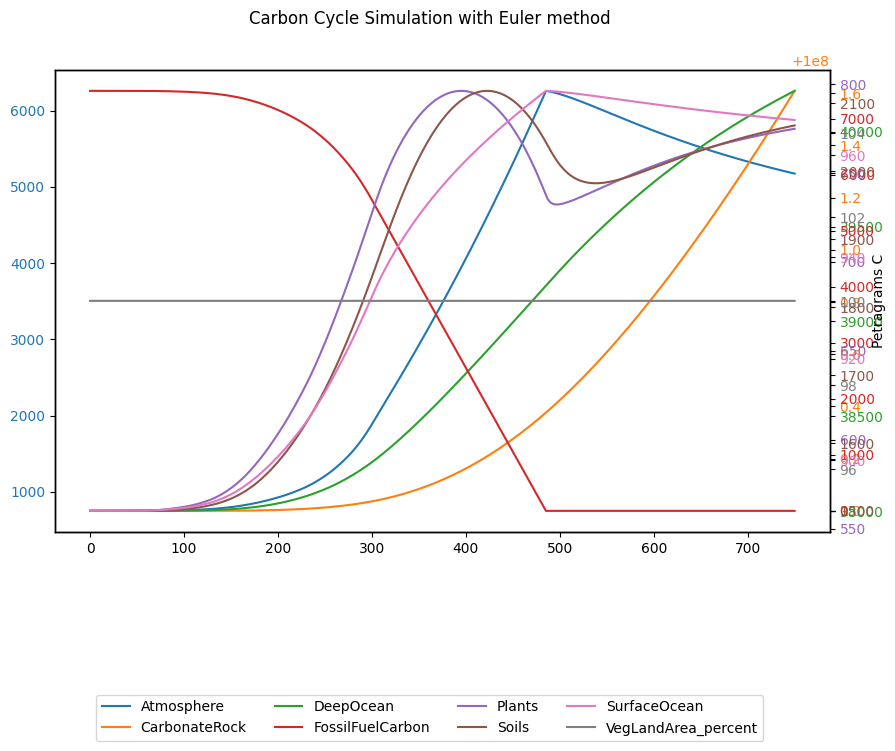

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(t, y[:,0], label='Atmosphere', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()
ax2.plot(t, y[:,1], label='CarbonateRock', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')

ax3 = ax1.twinx()
ax3.plot(t, y[:,2], label='DeepOcean', color='C2')
ax3.tick_params(axis='y', labelcolor='C2')

ax4 = ax1.twinx()
ax4.plot(t, y[:,3], label='FossilFuelCarbon', color='C3')
ax4.tick_params(axis='y', labelcolor='C3')

ax5 = ax1.twinx()
ax5.plot(t, y[:,4], label='Plants', color='C4')
ax5.tick_params(axis='y', labelcolor='C4')

ax6 = ax1.twinx()
ax6.plot(t, y[:,5], label='Soils', color='C5')
ax6.tick_params(axis='y', labelcolor='C5')

ax7 = ax1.twinx()
ax7.plot(t, y[:,6], label='SurfaceOcean', color='C6')
ax7.tick_params(axis='y', labelcolor='C6')

ax8 = ax1.twinx()
ax8.plot(t, y[:,7], label='VegLandArea_percent', color='C7')
ax8.tick_params(axis='y', labelcolor='C7')


fig.suptitle('Carbon Cycle Simulation with Euler method')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.ylabel('Petragrams C')
plt.xlabel('Time (years)')
plt.show()

**Improved Euler method**

In [ ]:
f = derivative
y0 = x0
t0 = 0.0
tf = 750.0
h = 0.01

# Solve the ODE using the Euler method
y, t = improved_euler(derivative, y0, t0, tf, h)

# Print the final state
print(y[-1])

[ 5.17286624e+03  1.00000002e+08  4.02161932e+04 -1.50000000e-01
  7.74813995e+02  2.06769248e+03  9.66974998e+02  1.00000000e+02]


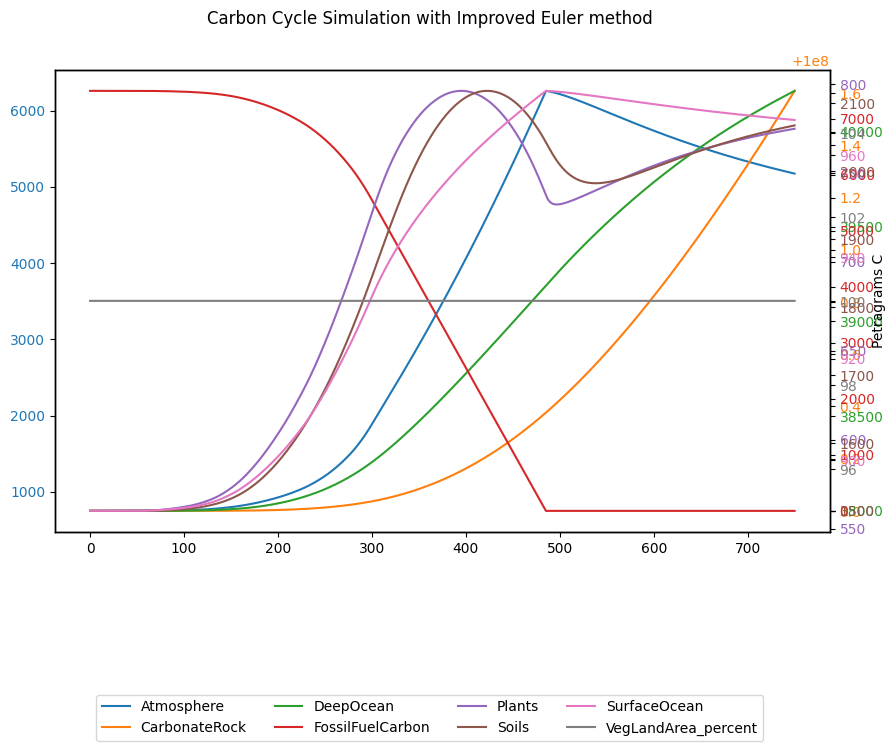

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(t, y[:,0], label='Atmosphere', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()
ax2.plot(t, y[:,1], label='CarbonateRock', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')

ax3 = ax1.twinx()
ax3.plot(t, y[:,2], label='DeepOcean', color='C2')
ax3.tick_params(axis='y', labelcolor='C2')

ax4 = ax1.twinx()
ax4.plot(t, y[:,3], label='FossilFuelCarbon', color='C3')
ax4.tick_params(axis='y', labelcolor='C3')

ax5 = ax1.twinx()
ax5.plot(t, y[:,4], label='Plants', color='C4')
ax5.tick_params(axis='y', labelcolor='C4')

ax6 = ax1.twinx()
ax6.plot(t, y[:,5], label='Soils', color='C5')
ax6.tick_params(axis='y', labelcolor='C5')

ax7 = ax1.twinx()
ax7.plot(t, y[:,6], label='SurfaceOcean', color='C6')
ax7.tick_params(axis='y', labelcolor='C6')

ax8 = ax1.twinx()
ax8.plot(t, y[:,7], label='VegLandArea_percent', color='C7')
ax8.tick_params(axis='y', labelcolor='C7')


fig.suptitle('Carbon Cycle Simulation with Improved Euler method')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.ylabel('Petragrams C')
plt.xlabel('Time (years)')
plt.show()

**Midpoint method**

In [ ]:
y0=x0
t0 = 0
tf = 750
h = 0.01

y, t = midpoint(derivative, x0, t0, tf, h)
print(y[-1])

[ 5.17286624e+03  1.00000002e+08  4.02161932e+04 -1.50000000e-01
  7.74813995e+02  2.06769248e+03  9.66974998e+02  1.00000000e+02]


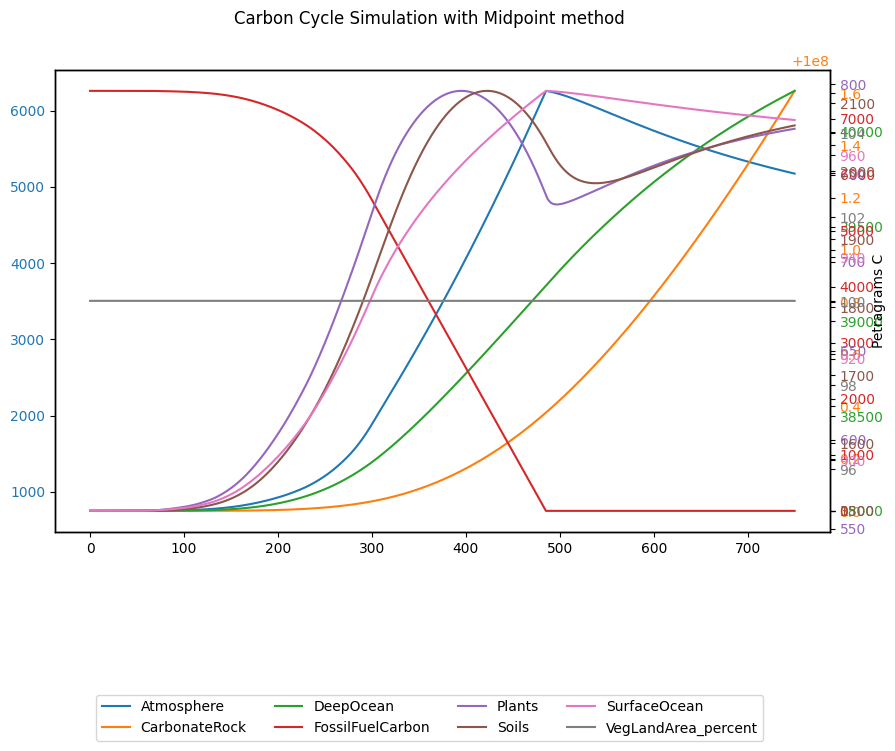

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(t, y[:,0], label='Atmosphere', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()
ax2.plot(t, y[:,1], label='CarbonateRock', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')

ax3 = ax1.twinx()
ax3.plot(t, y[:,2], label='DeepOcean', color='C2')
ax3.tick_params(axis='y', labelcolor='C2')

ax4 = ax1.twinx()
ax4.plot(t, y[:,3], label='FossilFuelCarbon', color='C3')
ax4.tick_params(axis='y', labelcolor='C3')

ax5 = ax1.twinx()
ax5.plot(t, y[:,4], label='Plants', color='C4')
ax5.tick_params(axis='y', labelcolor='C4')

ax6 = ax1.twinx()
ax6.plot(t, y[:,5], label='Soils', color='C5')
ax6.tick_params(axis='y', labelcolor='C5')

ax7 = ax1.twinx()
ax7.plot(t, y[:,6], label='SurfaceOcean', color='C6')
ax7.tick_params(axis='y', labelcolor='C6')

ax8 = ax1.twinx()
ax8.plot(t, y[:,7], label='VegLandArea_percent', color='C7')
ax8.tick_params(axis='y', labelcolor='C7')


fig.suptitle('Carbon Cycle Simulation with Midpoint method')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.ylabel('Petragrams C')
plt.xlabel('Time (years)')
plt.show()

**Runge-Kutta method of order 4**

In [ ]:
y0 = x0
t0 = 0
tf = 750
h = 0.01

y, t = rk4(derivative, y0, t0, tf, h)

y[-1]

array([ 5.17281655e+03,  1.00000002e+08,  4.02161873e+04, -9.99999998e-02,
        7.74815518e+02,  2.06769689e+03,  9.66974699e+02,  1.00000000e+02])

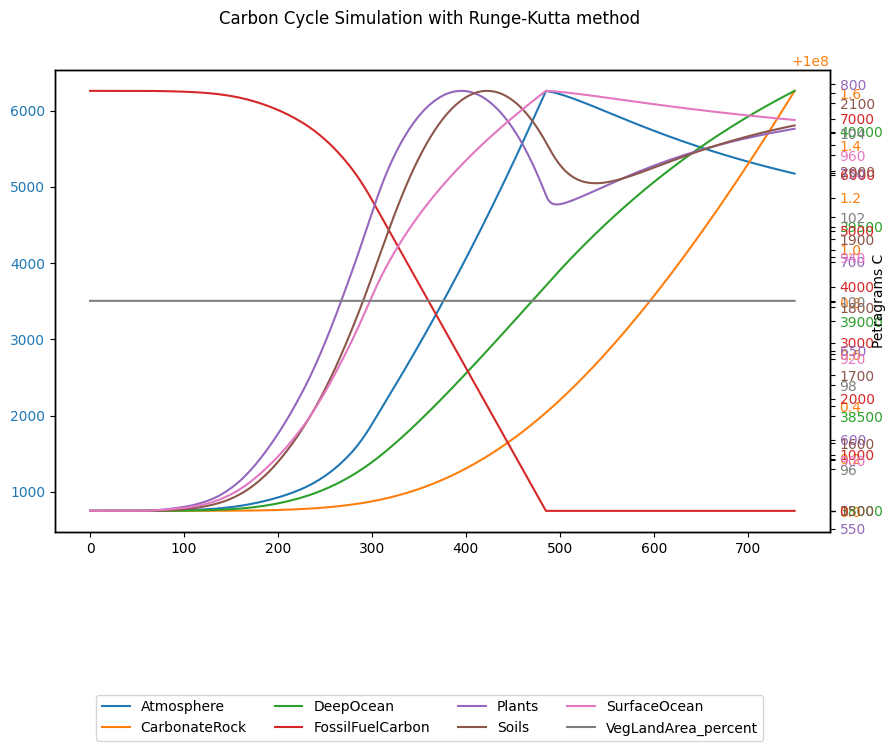

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(t, y[:,0], label='Atmosphere', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()
ax2.plot(t, y[:,1], label='CarbonateRock', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')

ax3 = ax1.twinx()
ax3.plot(t, y[:,2], label='DeepOcean', color='C2')
ax3.tick_params(axis='y', labelcolor='C2')

ax4 = ax1.twinx()
ax4.plot(t, y[:,3], label='FossilFuelCarbon', color='C3')
ax4.tick_params(axis='y', labelcolor='C3')

ax5 = ax1.twinx()
ax5.plot(t, y[:,4], label='Plants', color='C4')
ax5.tick_params(axis='y', labelcolor='C4')

ax6 = ax1.twinx()
ax6.plot(t, y[:,5], label='Soils', color='C5')
ax6.tick_params(axis='y', labelcolor='C5')

ax7 = ax1.twinx()
ax7.plot(t, y[:,6], label='SurfaceOcean', color='C6')
ax7.tick_params(axis='y', labelcolor='C6')

ax8 = ax1.twinx()
ax8.plot(t, y[:,7], label='VegLandArea_percent', color='C7')
ax8.tick_params(axis='y', labelcolor='C7')


fig.suptitle('Carbon Cycle Simulation with Runge-Kutta method')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.ylabel('Petragrams C')
plt.xlabel('Time (years)')
plt.show()

**Adams-Bashforth method**

In [ ]:
y0 = x0
t0 = 0
tf = 750
h = 0.01

y, t = adams_bashforth_2(derivative, y0, t0, tf, h)

y[-1]

array([ 5.17301533e+03,  1.00000002e+08,  4.02162110e+04, -3.00000000e-01,
        7.74809425e+02,  2.06767924e+03,  9.66975897e+02,  1.00000000e+02])

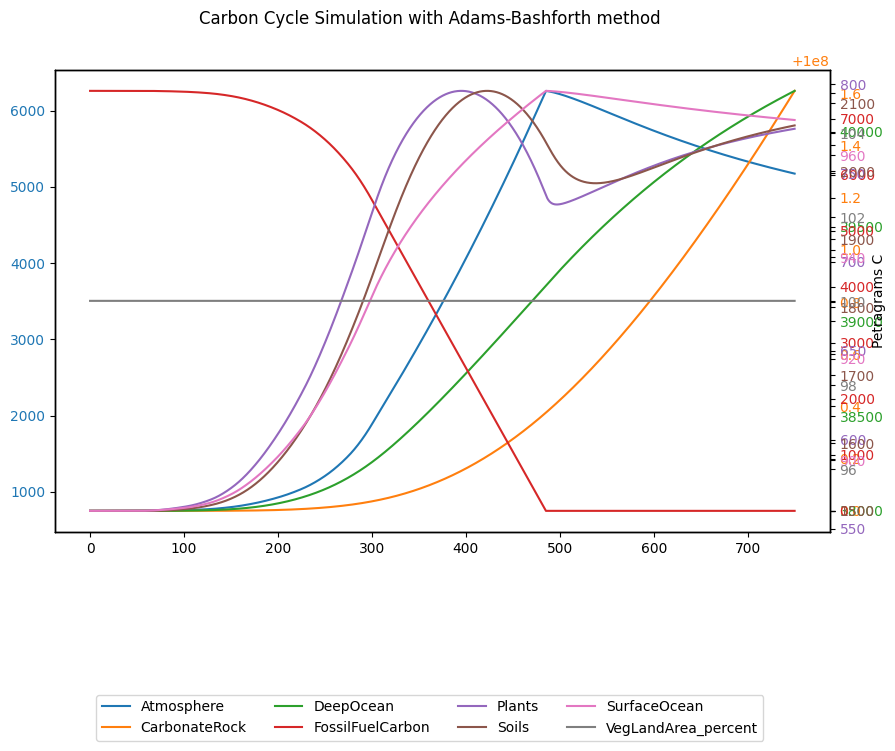

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(t, y[:,0], label='Atmosphere', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()
ax2.plot(t, y[:,1], label='CarbonateRock', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')

ax3 = ax1.twinx()
ax3.plot(t, y[:,2], label='DeepOcean', color='C2')
ax3.tick_params(axis='y', labelcolor='C2')

ax4 = ax1.twinx()
ax4.plot(t, y[:,3], label='FossilFuelCarbon', color='C3')
ax4.tick_params(axis='y', labelcolor='C3')

ax5 = ax1.twinx()
ax5.plot(t, y[:,4], label='Plants', color='C4')
ax5.tick_params(axis='y', labelcolor='C4')

ax6 = ax1.twinx()
ax6.plot(t, y[:,5], label='Soils', color='C5')
ax6.tick_params(axis='y', labelcolor='C5')

ax7 = ax1.twinx()
ax7.plot(t, y[:,6], label='SurfaceOcean', color='C6')
ax7.tick_params(axis='y', labelcolor='C6')

ax8 = ax1.twinx()
ax8.plot(t, y[:,7], label='VegLandArea_percent', color='C7')
ax8.tick_params(axis='y', labelcolor='C7')


fig.suptitle('Carbon Cycle Simulation with Adams-Bashforth method')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.ylabel('Petragrams C')
plt.xlabel('Time (years)')
plt.show()

**Adams-Moulton method**

In [ ]:
y0 = x0
t0 = 0
tf = 750
h = 0.01

y, t = adams_moulton_2(derivative, y0, t0, tf, h)

y[-1]

array([ 5.17286624e+03,  1.00000002e+08,  4.02161932e+04, -1.50000000e-01,
        7.74813995e+02,  2.06769248e+03,  9.66974998e+02,  1.00000000e+02])

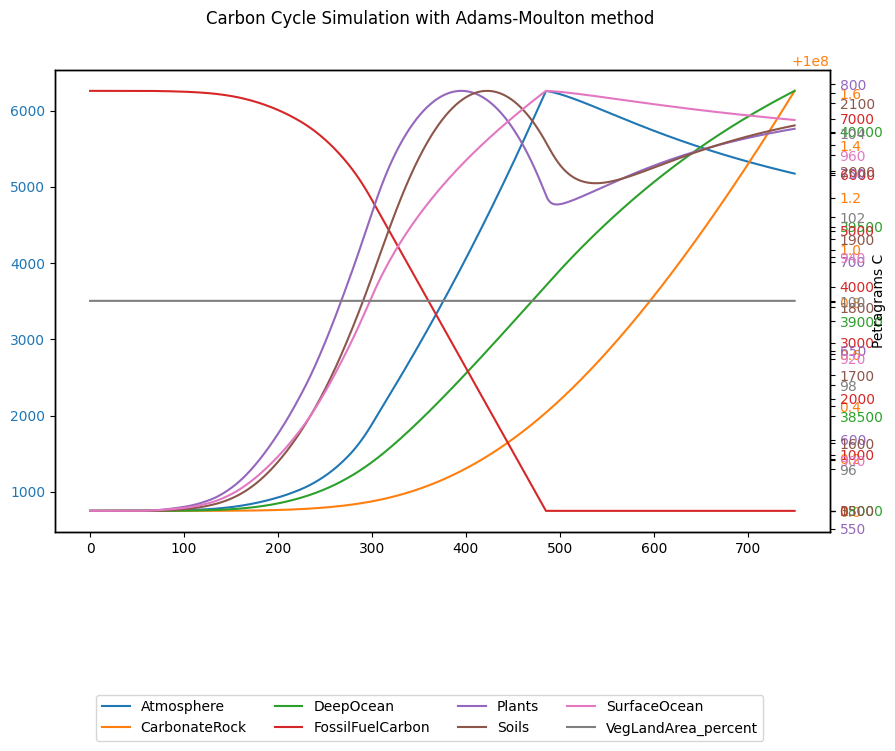

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(t, y[:,0], label='Atmosphere', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()
ax2.plot(t, y[:,1], label='CarbonateRock', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')

ax3 = ax1.twinx()
ax3.plot(t, y[:,2], label='DeepOcean', color='C2')
ax3.tick_params(axis='y', labelcolor='C2')

ax4 = ax1.twinx()
ax4.plot(t, y[:,3], label='FossilFuelCarbon', color='C3')
ax4.tick_params(axis='y', labelcolor='C3')

ax5 = ax1.twinx()
ax5.plot(t, y[:,4], label='Plants', color='C4')
ax5.tick_params(axis='y', labelcolor='C4')

ax6 = ax1.twinx()
ax6.plot(t, y[:,5], label='Soils', color='C5')
ax6.tick_params(axis='y', labelcolor='C5')

ax7 = ax1.twinx()
ax7.plot(t, y[:,6], label='SurfaceOcean', color='C6')
ax7.tick_params(axis='y', labelcolor='C6')

ax8 = ax1.twinx()
ax8.plot(t, y[:,7], label='VegLandArea_percent', color='C7')
ax8.tick_params(axis='y', labelcolor='C7')


fig.suptitle('Carbon Cycle Simulation with Adams-Moulton method')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.ylabel('Petragrams C')
plt.xlabel('Time (years)')
plt.show()

**Euler adaptive method**

In [ ]:
y0 = x0
t0 = 0
tf = 750
h = 0.1
tol = 1e-6

y, t, h = euler_adaptive(derivative, y0, t0, tf, h, tol)
y[-1]
h[-1]

0.0161191950374515

In [ ]:
y[-1]

array([ 5.17270451e+03,  1.00000002e+08,  4.02161865e+04, -2.18314640e-05,
        7.74818962e+02,  2.06770702e+03,  9.66974026e+02,  1.00000000e+02])

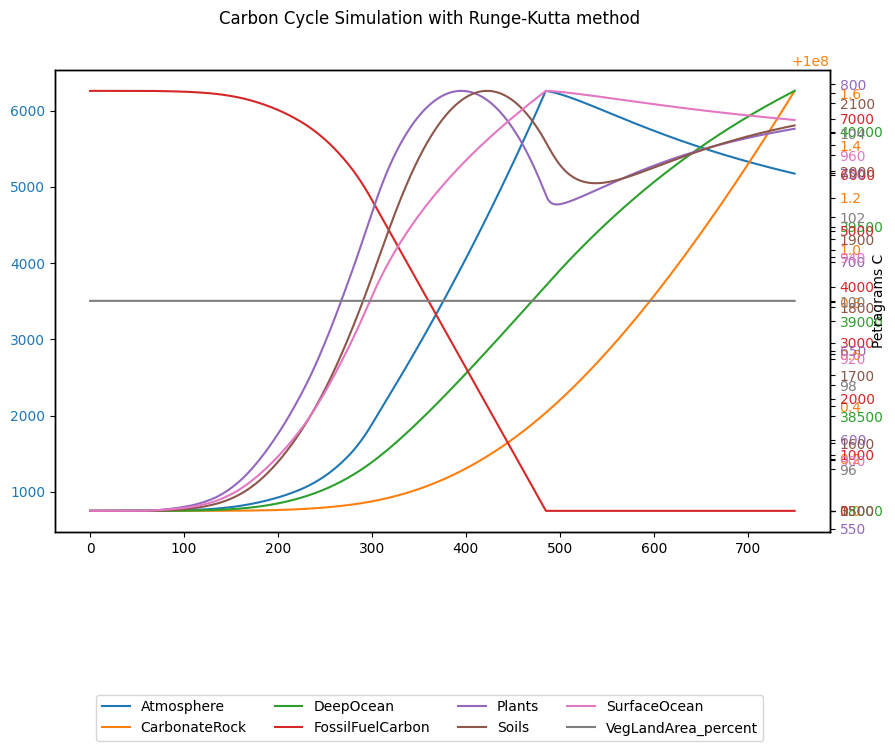

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(t, y[:,0], label='Atmosphere', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()
ax2.plot(t, y[:,1], label='CarbonateRock', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')

ax3 = ax1.twinx()
ax3.plot(t, y[:,2], label='DeepOcean', color='C2')
ax3.tick_params(axis='y', labelcolor='C2')

ax4 = ax1.twinx()
ax4.plot(t, y[:,3], label='FossilFuelCarbon', color='C3')
ax4.tick_params(axis='y', labelcolor='C3')

ax5 = ax1.twinx()
ax5.plot(t, y[:,4], label='Plants', color='C4')
ax5.tick_params(axis='y', labelcolor='C4')

ax6 = ax1.twinx()
ax6.plot(t, y[:,5], label='Soils', color='C5')
ax6.tick_params(axis='y', labelcolor='C5')

ax7 = ax1.twinx()
ax7.plot(t, y[:,6], label='SurfaceOcean', color='C6')
ax7.tick_params(axis='y', labelcolor='C6')

ax8 = ax1.twinx()
ax8.plot(t, y[:,7], label='VegLandArea_percent', color='C7')
ax8.tick_params(axis='y', labelcolor='C7')


fig.suptitle('Carbon Cycle Simulation with Adaptive Euler')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.ylabel('Petragrams C')
plt.xlabel('Time (years)')
plt.show()


**Runge-Kutta adaptive method**

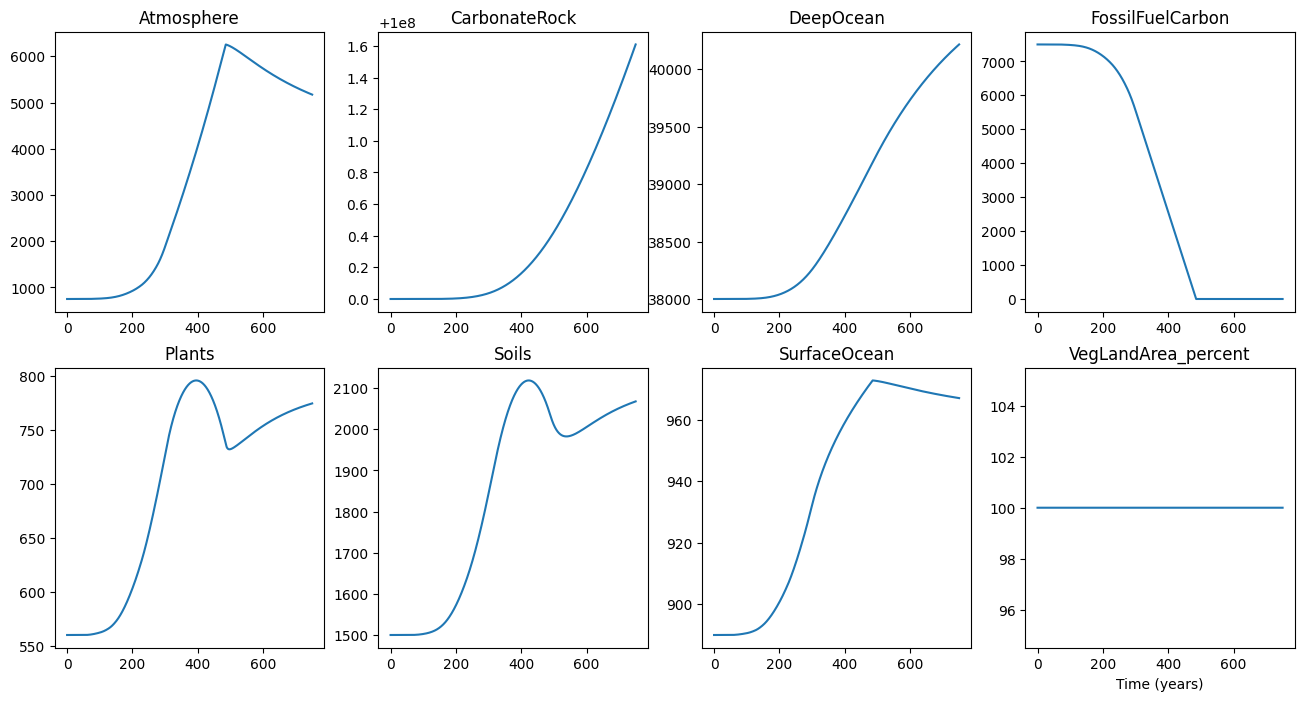

In [ ]:
y0 = x0
t0 = 0
tf = 750
h = 0.1
tol = 1e-2

y, t, h = rk4_adaptive(derivative, y0, t0, tf, h, tol)

fig, axs = plt.subplots(2, 4, figsize=(16,8))
axs[0,0].plot(t, y[:,0])
axs[0,0].set_title('Atmosphere')
axs[0,1].plot(t, y[:,1])
axs[0,1].set_title('CarbonateRock')
axs[0,2].plot(t, y[:,2])
axs[0,2].set_title('DeepOcean')
axs[0,3].plot(t, y[:,3])
axs[0,3].set_title('FossilFuelCarbon')
axs[1,0].plot(t, y[:,4])
axs[1,0].set_title('Plants')
axs[1,1].plot(t, y[:,5])
axs[1,1].set_title('Soils')
axs[1,2].plot(t, y[:,6])
axs[1,2].set_title('SurfaceOcean')
axs[1,3].plot(t, y[:,7])
axs[1,3].set_title('VegLandArea_percent')
plt.xlabel('Time (years)')
plt.show()


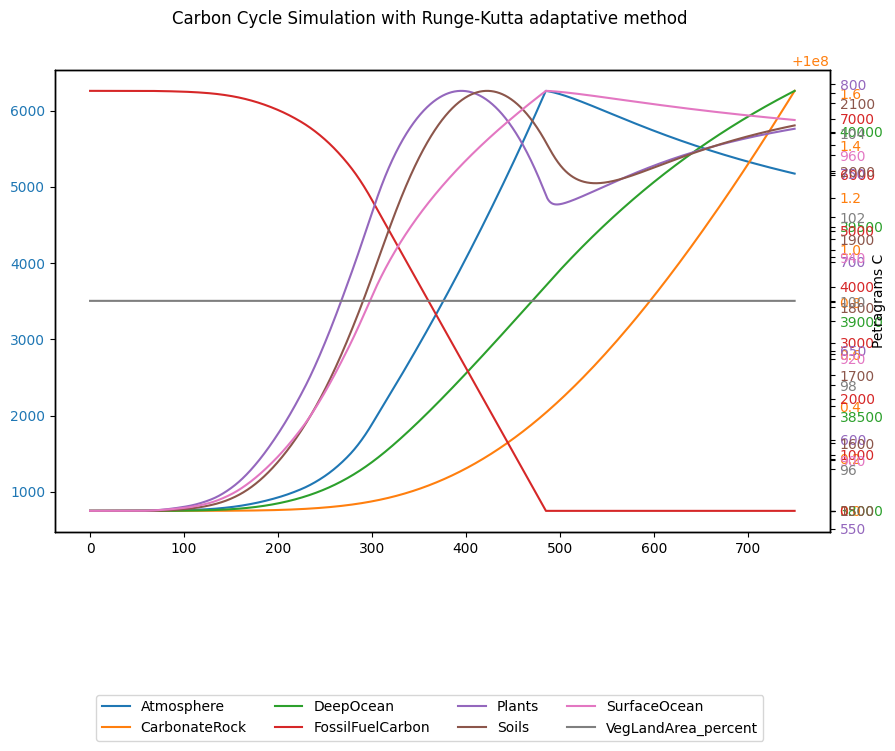

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(t, y[:,0], label='Atmosphere', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()
ax2.plot(t, y[:,1], label='CarbonateRock', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')

ax3 = ax1.twinx()
ax3.plot(t, y[:,2], label='DeepOcean', color='C2')
ax3.tick_params(axis='y', labelcolor='C2')

ax4 = ax1.twinx()
ax4.plot(t, y[:,3], label='FossilFuelCarbon', color='C3')
ax4.tick_params(axis='y', labelcolor='C3')

ax5 = ax1.twinx()
ax5.plot(t, y[:,4], label='Plants', color='C4')
ax5.tick_params(axis='y', labelcolor='C4')

ax6 = ax1.twinx()
ax6.plot(t, y[:,5], label='Soils', color='C5')
ax6.tick_params(axis='y', labelcolor='C5')

ax7 = ax1.twinx()
ax7.plot(t, y[:,6], label='SurfaceOcean', color='C6')
ax7.tick_params(axis='y', labelcolor='C6')

ax8 = ax1.twinx()
ax8.plot(t, y[:,7], label='VegLandArea_percent', color='C7')
ax8.tick_params(axis='y', labelcolor='C7')


fig.suptitle('Carbon Cycle Simulation with Runge-Kutta adaptive method')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.ylabel('Petragrams C')
plt.xlabel('Time (years)')
plt.show()

In [ ]:
#Solution
y[-1]

array([ 5.17275115e+03,  1.00000002e+08,  4.02161516e+04, -6.02657000e-03,
        7.74817511e+02,  2.06770245e+03,  9.66974299e+02,  1.00000000e+02])

**Midpoint adaptive method**

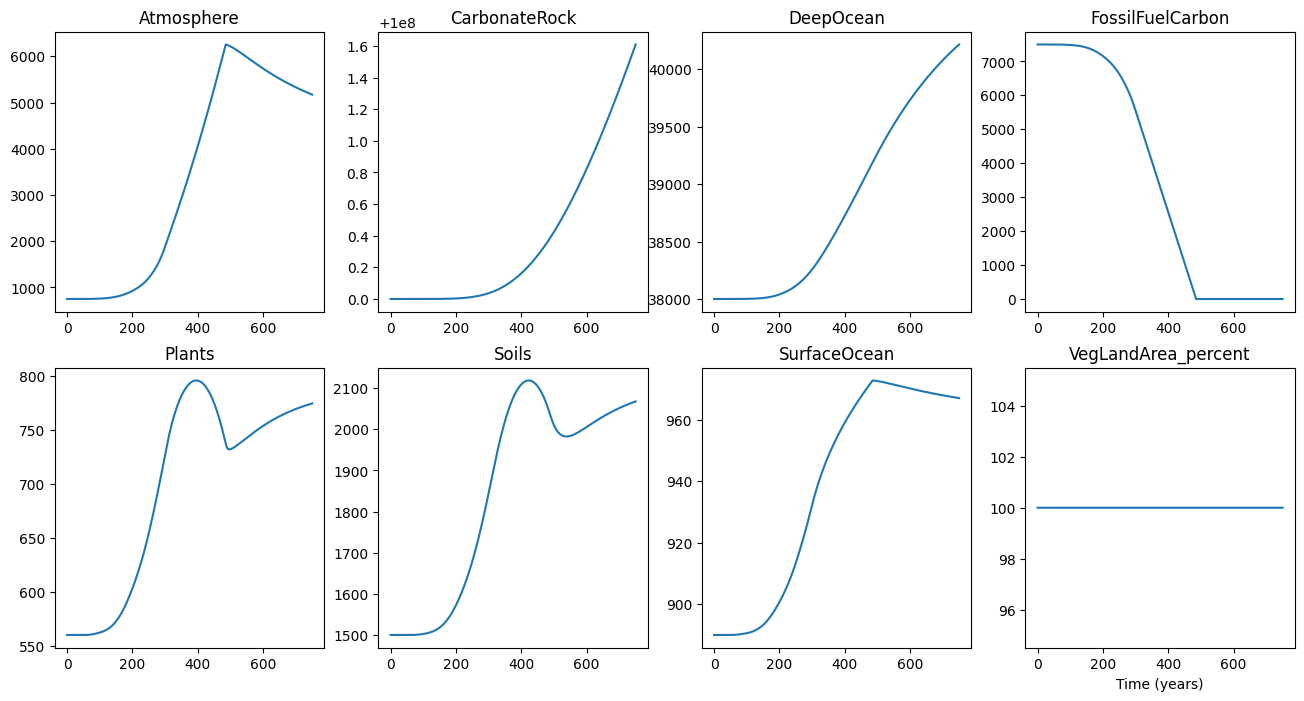

In [ ]:
y0 = x0
t0 = 0
tf = 750
h = 0.1
tol = 1e-2

y, t, h = midpoint_adaptive(derivative, y0, t0, tf, h, tol)

fig, axs = plt.subplots(2, 4, figsize=(16,8))
axs[0,0].plot(t, y[:,0])
axs[0,0].set_title('Atmosphere')
axs[0,1].plot(t, y[:,1])
axs[0,1].set_title('CarbonateRock')
axs[0,2].plot(t, y[:,2])
axs[0,2].set_title('DeepOcean')
axs[0,3].plot(t, y[:,3])
axs[0,3].set_title('FossilFuelCarbon')
axs[1,0].plot(t, y[:,4])
axs[1,0].set_title('Plants')
axs[1,1].plot(t, y[:,5])
axs[1,1].set_title('Soils')
axs[1,2].plot(t, y[:,6])
axs[1,2].set_title('SurfaceOcean')
axs[1,3].plot(t, y[:,7])
axs[1,3].set_title('VegLandArea_percent')
plt.xlabel('Time (years)')
plt.show()




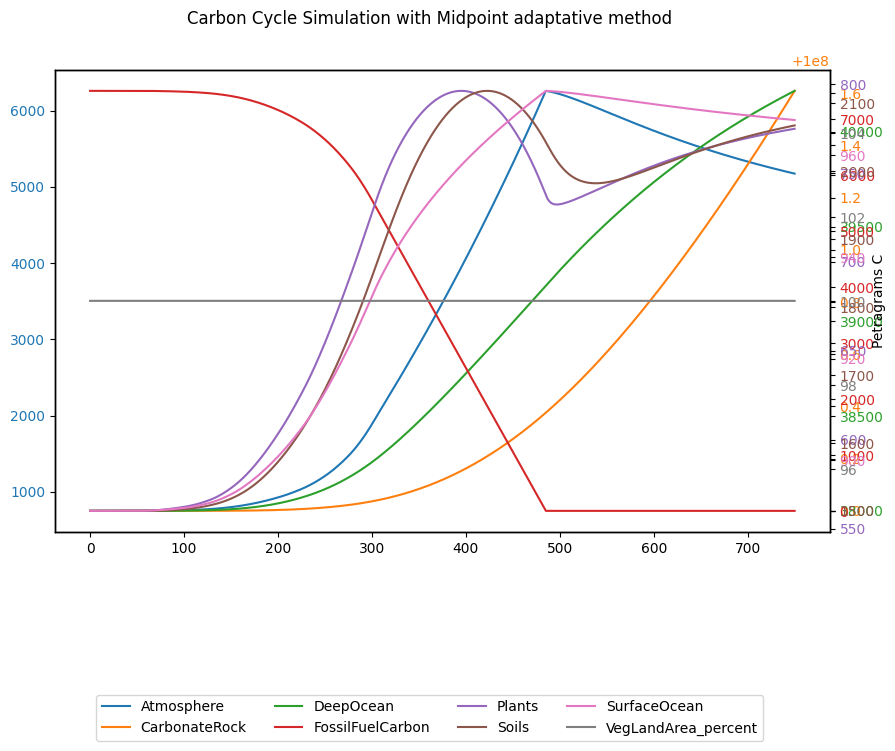

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(t, y[:,0], label='Atmosphere', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()
ax2.plot(t, y[:,1], label='CarbonateRock', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')

ax3 = ax1.twinx()
ax3.plot(t, y[:,2], label='DeepOcean', color='C2')
ax3.tick_params(axis='y', labelcolor='C2')

ax4 = ax1.twinx()
ax4.plot(t, y[:,3], label='FossilFuelCarbon', color='C3')
ax4.tick_params(axis='y', labelcolor='C3')

ax5 = ax1.twinx()
ax5.plot(t, y[:,4], label='Plants', color='C4')
ax5.tick_params(axis='y', labelcolor='C4')

ax6 = ax1.twinx()
ax6.plot(t, y[:,5], label='Soils', color='C5')
ax6.tick_params(axis='y', labelcolor='C5')

ax7 = ax1.twinx()
ax7.plot(t, y[:,6], label='SurfaceOcean', color='C6')
ax7.tick_params(axis='y', labelcolor='C6')

ax8 = ax1.twinx()
ax8.plot(t, y[:,7], label='VegLandArea_percent', color='C7')
ax8.tick_params(axis='y', labelcolor='C7')


fig.suptitle('Carbon Cycle Simulation with Midpoint adaptive method')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.ylabel('Petragrams C')
plt.xlabel('Time (years)')
plt.show()

In [ ]:
#Solution
y[-1]

array([5.17257297e+03, 1.00000002e+08, 4.02162554e+04, 9.49336949e-02,
       7.74811026e+02, 2.06768059e+03, 9.66975939e+02, 1.00000000e+02])

##Comparison of the performance of numerical methods

To compare the performance of different numerical methods, we can compute the solutions to the same differential equation using each method for different values of h, and then compare the accuracy and consistency of each method. We can also compare the stability of each method for different types of differential equations.

###Consistency



In [ ]:
s = 0
y0 = x0
t0 = 0
tf = 750
h = 1e-2
y, t = euler(derivative, y0, t0, tf, h)
for i in range(0,749,1):
  s=s+np.abs(y[i+1] - y[i])
print(s)

[0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
s=0
y0 = x0
t0 = 0
tf = 750
h = 1e-2
y, t = rk4(derivative, y0, t0, tf, h)
for i in range(0,748,1):
  s=s+np.abs(y[i+1] - y[i])
print(s)

[0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
s=0
y0 = x0
t0 = 0
tf = 750
h = 1e-2
y, t = midpoint(derivative, y0, t0, tf, h)
for i in range(0,748,1):
  s=s+np.abs(y[i+1] - y[i])
print(s)

[0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
s=0
y0 = x0
t0 = 0
tf = 750
h = 1e-2
y, t = adams_bashforth_2(derivative, y0, t0, tf, h)
for i in range(0,748,1):
  s=s+np.abs(y[i+1] - y[i])
print(s)

[0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
s=0
y0 = x0
t0 = 0
tf = 750
h = 1e-2
y, t = adams_moulton_2(derivative, y0, t0, tf, h)
for i in range(0,748,1):
  s=s+np.abs(y[i+1] - y[i])
print(s)

[0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
s=0
y0 = x0
t0 = 0
tf = 750
h = 1e-2
tol = 1e-2
y, t, h = euler_adaptive(derivative, y0, t0, tf, h, tol)
for i in range(0,748,1):
  s=s+np.abs(y[i+1] - y[i])
print(s)

[0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
s=0
y0 = x0
t0 = 0
tf = 750
h = 1e-2
tol = 1e-2
y, t, h = rk4_adaptive(derivative, y0, t0, tf, h, tol)
for i in range(0,748,1):
  s=s+np.abs(y[i+1] - y[i])
print(s)

[0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
s=0
y0 = x0
t0 = 0
tf = 750
h = 1e-2
tol = 1e-2
y, t, h = midpoint_adaptive(derivative, y0, t0, tf, h, tol)
for i in range(0,748,1):
  s=s+np.abs(y[i+1] - y[i])
print(s)

[0. 0. 0. 0. 0. 0. 0. 0.]


All studied methods are consistent.

###Accuracy

One way to compare the performance of different methods is to measure their accuracy. The accuracy of a method can be determined by comparing the numerical solution to the exact solution (if available) or to a higher-order method. A method with a smaller error is considered more accurate.

**With a test function**

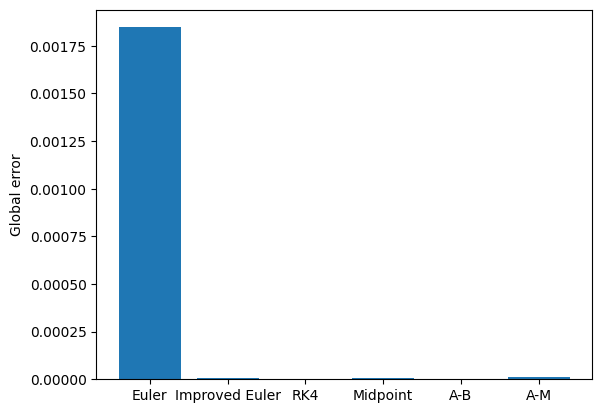

In [ ]:
def f(y, t):
    return -y

def true_solution(t):
    return np.exp(-t)

y0 = 1
t0 = 0
tf = 1
h = 0.01
methods = [euler, improved_euler, rk4, midpoint, adams_bashforth_2, adams_moulton_2]
errors = []

for method in methods:
    y_history, t_history = method(f, y0, t0, tf, h)
    global_error = np.abs(y_history[-1] - true_solution(tf))
    errors.append(global_error)

# Plot the results
plt.bar(["Euler", "Improved Euler", "RK4", "Midpoint", "A-B", "A-M"], errors)
plt.ylabel("Global error")
plt.show()

###Convergence

A method is said to be convergent if the numerical solution approaches the exact solution as the step size (or time step) is decreased. One way to compare the performance of different methods is to plot the error against the step size and observe the convergence behavior.

**Theorem 4. If the method is stable and consistent, then it is convergent.**

###Stability

A method is said to be stable if the solution remains bounded as the number of steps increases (or equivalently, as the step size decreases). One way to compare the performance of different methods is to plot the solution against time and observe the stability behavior.

<ipython-input-349-9aee1fcfd787>:18: RuntimeWarning: invalid value encountered in sqrt
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
<ipython-input-349-9aee1fcfd787>:10: RuntimeWarning: overflow encountered in double_scalars
  return ((60 - GlobalTemp) * (GlobalTemp + 15)) / (((60 + 15) / 2) ** (2))/.96
<ipython-input-349-9aee1fcfd787>:6: RuntimeWarning: invalid value encountered in double_scalars
  return 1.5 * ((AtmCO2) - 40) / ((AtmCO2) + 80)
<ipython-input-349-9aee1fcfd787>:18: RuntimeWarning: overflow encountered in double_scalars
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
<ipython-input-349-9aee1fcfd787>:18: RuntimeWarning: invalid value encountered in double_scalars
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
<ipython-input-349-9aee1fcfd787>:22: RuntimeWarning: invalid value encountered in double_scalars
  return 280*KCO2*(HCO3**2/CO3)


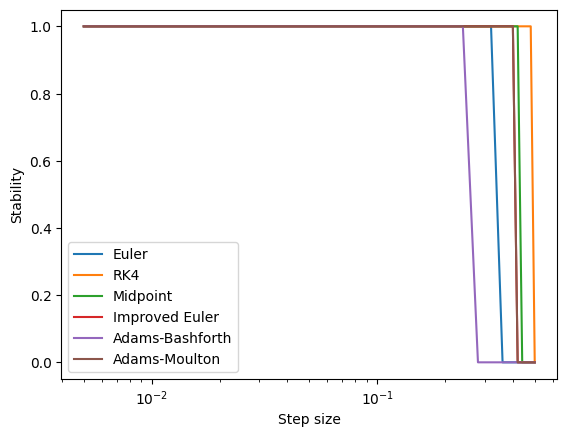

In [ ]:
f = derivative
y0 = x0
t0 = 0
tf = 750
methods = [euler, rk4, midpoint, improved_euler, adams_bashforth_2, adams_moulton_2]
step_sizes = [0.5, 0.48, 0.46, 0.44, 0.42, 0.40, 0.36, 0.32, 0.28, 0.24, 0.2, 0.1, 0.05, 0.01, 0.005]
stability = []

for method in methods:
    method_stability = []
    for h in step_sizes:
        y_history, t_history = method(f, y0, t0, tf, h)
        stable = np.all(np.abs(y_history) < 1e10)
        method_stability.append(stable)
    stability.append(method_stability)

# Plot the results
plt.plot(step_sizes, stability[0], label="Euler")
plt.plot(step_sizes, stability[1], label="RK4")
plt.plot(step_sizes, stability[2], label="Midpoint")
plt.plot(step_sizes, stability[3], label="Improved Euler")
plt.plot(step_sizes, stability[4], label="Adams-Bashforth")
plt.plot(step_sizes, stability[5], label="Adams-Moulton")
plt.xscale("log")
plt.xlabel("Step size")
plt.ylabel("Stability")
plt.legend()
plt.show()

###Computational time

Another way to compare the performance of different methods is to measure the computational time required to obtain the numerical solution. A method that requires less computational time is considered more efficient.

**Computational time comparison for constant stepsize methods**

<ipython-input-349-9aee1fcfd787>:18: RuntimeWarning: invalid value encountered in sqrt
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
<ipython-input-349-9aee1fcfd787>:10: RuntimeWarning: overflow encountered in double_scalars
  return ((60 - GlobalTemp) * (GlobalTemp + 15)) / (((60 + 15) / 2) ** (2))/.96
<ipython-input-349-9aee1fcfd787>:6: RuntimeWarning: invalid value encountered in double_scalars
  return 1.5 * ((AtmCO2) - 40) / ((AtmCO2) + 80)
<ipython-input-349-9aee1fcfd787>:18: RuntimeWarning: overflow encountered in double_scalars
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
<ipython-input-349-9aee1fcfd787>:18: RuntimeWarning: invalid value encountered in double_scalars
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)


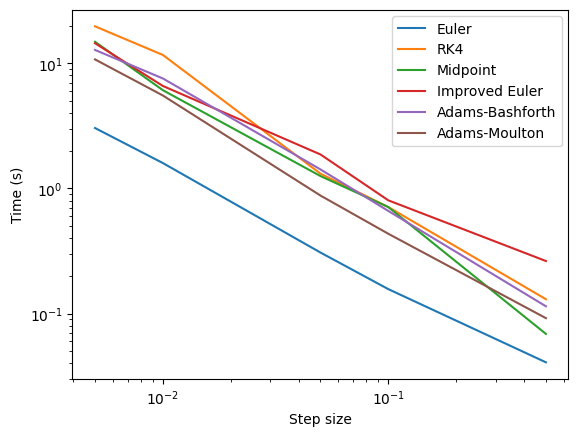

In [ ]:
import time

y0 = x0
t0 = 0
tf = 750
methods = [euler, rk4, midpoint, improved_euler, adams_bashforth_2, adams_moulton_2]
step_sizes = [0.5, 0.1, 0.05, 0.01, 0.005]
times = []

for method in methods:
    method_times = []
    for h in step_sizes:
        start_time = time.time()
        method(f, y0, t0, tf, h)
        method_time = time.time() - start_time
        method_times.append(method_time)
    times.append(method_times)

# Plot the results
plt.plot(step_sizes, times[0], label="Euler")
plt.plot(step_sizes, times[1], label="RK4")
plt.plot(step_sizes, times[2], label="Midpoint")
plt.plot(step_sizes, times[3], label="Improved Euler")
plt.plot(step_sizes, times[4], label="Adams-Bashforth")
plt.plot(step_sizes, times[5], label="Adams-Moulton")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Step size")
plt.ylabel("Time (s)")
plt.legend()
plt.show()


The computational time computed are coherent with the common knowledge; for example, Euler as the simplest method has the lowest computational time.
But the other methods are still more accurate, because they have the lowest global error as shown above.


We can observe that the more stable methods are also the methods, which have the highest computational cost. Thus the stability is negatively correlated with the computational time.



**Computational time comparison for nonconstant stepsize methods**

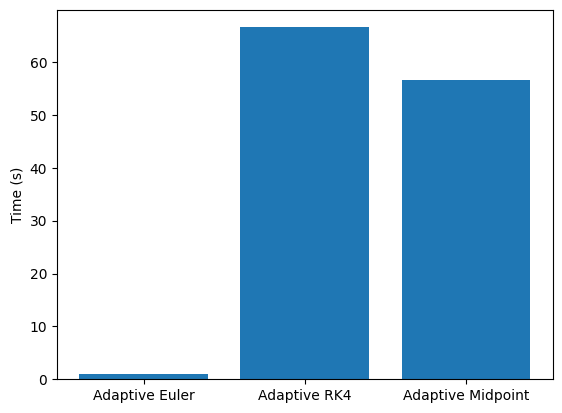

In [ ]:
import time


y0 = x0
t0 = 0
tf = 750
tol = 1e-2

methods = [euler_adaptive, rk4_adaptive, midpoint_adaptive]
step_sizes = [0.1]
times = []

for method in methods:
    method_times = []
    for h in step_sizes:
      start_time = time.time()
      y, t, h = method(f, y0, t0, tf, h, tol)
      method_time = time.time() - start_time
    times.append(method_time)

# Plot the results
method_names = ["Adaptive Euler", "Adaptive RK4", "Adaptive Midpoint"]
plt.bar(method_names, times)
plt.ylabel("Time (s)")
plt.show()